# Data Loading

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
file_id = '1o2qka7h7K1DJhj2hBoK7hLJpxe7gtc2-'
destination = 'cup.json'
download_file_from_google_drive(file_id, destination)

In [ ]:
import json
with open('cup.json', 'r') as fp:
    cup = json.load(fp)

In [ ]:
cup[0].keys()

dict_keys(['C1', 'C2', 'M1', 'M2'])

In [ ]:
comment_vocab = set()
code_vocab = set()
for sample in cup:
  comment_vocab |= set(sample['C1']) | set(sample['C2'])
  code_vocab |= set(sample['M1']) | set(sample['M2'])
print(len(comment_vocab), len(code_vocab))

11353 14901


In [ ]:
cup[0]

{'C1': ['▁get', '▁the', '▁p', 'im', '▁interface'],
 'C2': ['▁return', '▁the', '▁onos', '▁interface'],
 'M1': ['▁public',
  '▁interface',
  '▁get',
  '▁interface',
  '▁return',
  '▁the',
  '▁interface'],
 'M2': ['▁public',
  '▁interface',
  '▁get',
  '▁interface',
  '▁return',
  '▁this',
  '▁onos',
  '▁interface']}

In [ ]:
# "▁" is not equal to "_"
"▁public" in code_vocab, "▁" == "_"

(True, False)

In [ ]:
# c - token in comment, m - token im method
def id2c(id):
  return list(comment_vocab)[id - 1]

c2id = {c: id + 1 for id, c in enumerate(comment_vocab)}

In [ ]:
def id2m(id):
  return list(code_vocab)[id - 1]

m2id = {m: id + 1 for id, m in enumerate(code_vocab)}

In [ ]:
def tokens_to_ids(tokens, is_c):
  if is_c:
    return [c2id[c] for c in tokens]
  else:
    return [m2id[m] for m in tokens]
def ids_to_tokens(ids, is_c):
  if is_c:
    return [id2c(id) for id in ids]
  else:
    return [id2m(id) for id in ids]

In [ ]:
ids_to_tokens(tokens_to_ids(['▁if', '▁else', '▁print'], True), True)

['▁if', '▁else', '▁print']

In [ ]:
import tensorflow as tf

In [ ]:
def create_dataset(data):
  cX, mX = [], []
  Y = []
  for sample in data:
    C1 = tokens_to_ids(sample['C1'], is_c=True)
    C2 = tokens_to_ids(sample['C2'], is_c=True)
    M1 = tokens_to_ids(sample['M1'], is_c=False)
    M2 = tokens_to_ids(sample['M2'], is_c=False)
    # New code and old comment --> inconsistency 
    cX.append(C1)
    mX.append(M2)
    Y.append(1)
    # New code and new comment --> consistency
    cX.append(C2)
    mX.append(M2)
    Y.append(0)
  return cX, mX, Y

In [ ]:
cX, mX, Y = create_dataset(cup)

In [ ]:
from sklearn.model_selection import train_test_split
cX_train, cX_test, mX_train, mX_test, Y_train, Y_test = train_test_split(cX, mX, Y, test_size=0.2)

In [ ]:
# PAD sequences to max len
min(map(len, cX_train)), min(map(len, mX_train)) 

(3, 5)

In [ ]:
cX_train = tf.keras.preprocessing.sequence.pad_sequences(cX_train, value=0, padding='post')
mX_train = tf.keras.preprocessing.sequence.pad_sequences(mX_train, value=0, padding='post')

In [ ]:
cX_test = tf.keras.preprocessing.sequence.pad_sequences(cX_test, value=0, padding='post')
mX_test = tf.keras.preprocessing.sequence.pad_sequences(mX_test, value=0, padding='post')

In [ ]:
import numpy as np
def sample_data(cX, mX, Y, k = 5):
  for _ in range(k):
    id = np.random.randint(0, len(Y))
    C = cX[id]
    M = mX[id]
    C = list(filter(lambda x: x != 0, C))
    C = list(map(lambda x: id2c(x), C))
    M = list(filter(lambda x: x != 0, M))
    M = list(map(lambda x: id2m(x), M))
    print(f"C: {' '.join(C)} \n M: {' '.join(M)} \n {'Inconsistent' if Y[id] else 'Consistent'}")
sample_data(cX_train, mX_train, Y_train)

C: ▁note ▁that ▁code ▁null ▁is ▁a ▁default ▁local ▁instance ▁name 
 M: ▁public ▁ignite ▁configuration ▁set ▁ignite ▁instance ▁name ▁string ▁node ▁name ▁this ▁ignite ▁instance ▁name ▁node ▁name ▁return ▁this 
 Inconsistent
C: ▁url ▁encodes ▁a ▁given ▁string 
 M: ▁public ▁static ▁string ▁escape ▁string ▁source ▁return ▁encoder ▁escape ▁w ▁blanks ▁source 
 Inconsistent
C: ▁checks ▁whether ▁the ▁agent ▁is ▁currently ▁at ▁the ▁specified ▁location 
 M: ▁protected ▁agent ▁get ▁agent ▁object ▁location ▁vacuum ▁environment ▁e ▁get ▁vacuum ▁env ▁for ▁agent ▁a ▁e ▁get ▁agents ▁if ▁location ▁equals ▁e ▁get ▁agent ▁location ▁a ▁return ▁a ▁return 
 Inconsistent
C: ▁sets ▁the ▁default ▁condition ▁evaluation ▁listener ▁that ▁all ▁await ▁statements ▁will ▁use 
 M: ▁public ▁static ▁void ▁set ▁default ▁condition ▁evaluation ▁listener ▁condition ▁evaluation ▁listener ▁default ▁condition ▁evaluation ▁listener ▁await ility ▁default ▁condition ▁evaluation ▁listener ▁default ▁condition ▁evaluation ▁listener 


In [ ]:
import numpy as np
np.array(cX_train).shape

(60838, 52)

# Average em. model

In [ ]:
from tensorflow.keras import layers
m_vocab_size = len(code_vocab)
c_vocab_size = len(comment_vocab) 
embedding_size = 128

code_input = tf.keras.Input((None,), name='code')
comment_input = tf.keras.Input((None, ), name='comment')

code_features = layers.Embedding(input_dim=m_vocab_size + 1,
                                output_dim=embedding_size, mask_zero=True)(code_input)

comment_features = layers.Embedding(input_dim=c_vocab_size + 1,
                                output_dim=embedding_size, mask_zero=True)(comment_input)

dropout_rate = 0.2
code_features_d = layers.Dropout(dropout_rate)(code_features)

code_encoder = layers.GlobalAveragePooling1D()(code_features_d)

comment_features_d = layers.Dropout(dropout_rate)(comment_features)

comment_encoder = layers.GlobalAveragePooling1D()(comment_features_d)

encoder = layers.Concatenate()([code_encoder, comment_encoder])

encoder_d = layers.Dropout(dropout_rate)(encoder)
output = layers.Dense(1, name='out', activation='sigmoid')(encoder_d)

model = tf.keras.Model(inputs=[code_input, comment_input],
                        outputs=[output])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
code (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
comment (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    1907456     code[0][0]                       
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 128)    1453312     comment[0][0]                    
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras import losses
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics='accuracy')

In [ ]:
epochs = 5
history = model.fit(
    x={'code': np.array(mX_train), 'comment': np.array(cX_train)}, 
    y={'out': np.array(Y_train)},
    epochs=epochs,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
1521/1521 [==============================] - 49s 32ms/step - loss: 0.6954 - accuracy: 0.5027 - val_loss: 0.6907 - val_accuracy: 0.5081
Epoch 2/5
1521/1521 [==============================] - 48s 32ms/step - loss: 0.6850 - accuracy: 0.5238 - val_loss: 0.6906 - val_accuracy: 0.5222
Epoch 3/5
1521/1521 [==============================] - 48s 32ms/step - loss: 0.6733 - accuracy: 0.5640 - val_loss: 0.6934 - val_accuracy: 0.5219
Epoch 4/5
1521/1521 [==============================] - 49s 32ms/step - loss: 0.6631 - accuracy: 0.5972 - val_loss: 0.6977 - val_accuracy: 0.5218
Epoch 5/5
1521/1521 [==============================] - 48s 32ms/step - loss: 0.6546 - accuracy: 0.6241 - val_loss: 0.7002 - val_accuracy: 0.5232


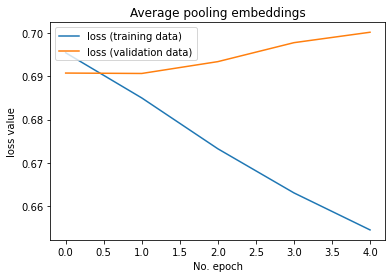

In [ ]:
# Plot history: MAE
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss (training data)')
plt.plot(history.history['val_loss'], label='loss (validation data)')
plt.title('Average pooling embeddings')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate({'code': np.array(mX_test), 'comment': np.array(cX_test)}, {'out': np.array(Y_test)})
print("test loss, test acc:", results)

Evaluate on test data
476/476 [==============================] - 2s 3ms/step - loss: 0.6969 - accuracy: 0.5245
test loss, test acc: [0.6969444155693054, 0.5245233178138733]


In [ ]:
index = 10
model.predict(x={'code': np.array([mX_train[index]]), 'comment': np.array([cX_train[index]])}), Y[index]

(array([[0.99586016]], dtype=float32), 1)

# TF-IDF

In [ ]:
# Example of TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

def create_translator(is_code):
  def tf_idf_tokenizer(ids):
    tokens = []
    for id in ids:
      if is_code and id == PAD_m:
        tokens.append('<PAD>')
      elif not is_code and id == PAD_c:
        tokens.append('<PAD>')
      else:
        if is_code:
          tokens.append(id2m(id))
        else:
          tokens.append(id2c(id))
    return tokens
  return tf_idf_tokenizer

corpus = [
     cX_train[0],
     cX_train[1],
    ]

vectorizer = TfidfVectorizer(max_features=5000, tokenizer=create_translator(False), lowercase=False, use_idf=True, sublinear_tf=True, norm='l2')
tf_cX = vectorizer.fit_transform(cX)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, tokenizer=create_translator(True), lowercase=False, use_idf=True, sublinear_tf=True, norm='l2')
tf_mX = vectorizer.fit_transform(mX)

In [ ]:
tf_X = np.hstack((np.array(tf_cX.toarray()), np.array(tf_mX.toarray())))

In [ ]:
tf_X.shape

In [ ]:
tf_X_train, tf_X_test, tf_Y_train, tf_Y_test, tf_ids_train, tf_ids_test = train_test_split(
    tf_X, 
    Y, 
    list(range(tf_X.shape[0])), test_size=.2, random_state=23)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

clf = SVC(random_state=1, kernel='linear', C=1e4)
clf.fit(tf_X_train, tf_Y_train)
y_pred = clf.predict(tf_X_test)

#print('Mean Accuracy on Test set: %.3f' %  (clf.score(tf_X_test, tf_Y_test)))
print('Calculating F1-Score on Prediction: ', f1_score(tf_Y_test, y_pred,  average='binary'))
print('Calculating F1-MacroAverage-Score on Prediction: ', f1_score(tf_Y_test, y_pred,  average='macro'))
print('Calculating RocAUC on Prediction: ', roc_auc_score(tf_Y_test, y_pred,  average='macro'))
#classify_samples(pipe_svc, param_grid, f1_score, scoring='f1',)